# Fixed point optimization of a piecewise linear function

In this demo, we implement a fixed-point version of a piecewise linear function:

```python
   y = max(a0*x + a1, a2*x+a3)
```

## Floating Point Version

We begin by writing a floating point version of the function.

In [25]:
import numpy as np
from numpy.typing import NDArray

def piecewise_float(
    x: NDArray[np.float64],  # shape (n,)
    a: NDArray[np.float64],  # shape (n, 4)
) -> NDArray[np.float64]:
    """
    Evaluate a piecewise linear function in floating point:
        y = max(a[:,0]*x + a[:,1], a[:,2]*x + a[:,3])
    """
    y = np.maximum(
        a[:,0] * x + a[:,1],
        a[:,2] * x + a[:,3] 
    )
    return y

To illustrate, we plot the function for some values:


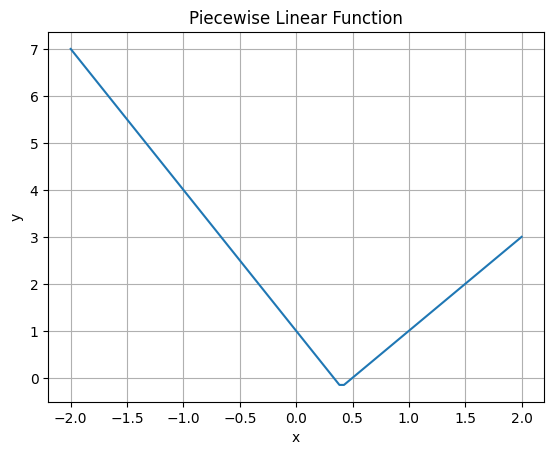

In [26]:
nplot = 100
xplot = np.linspace(-2.0, 2.0, nplot)
aplot = np.array([2.0, -1, -3.0, 1.0])
aplot = aplot[None,:].repeat(nplot, axis=0)

yplot = piecewise_float(xplot, aplot)
import matplotlib.pyplot as plt
plt.plot(xplot, yplot)
plt.title("Piecewise Linear Function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Create a Fixed Point Version

We now create a fixed point version. 
Some points:

- The fixed point version takes integer representations, `xint` and `aint` of `x` and `a`.
- These are in `Q(wid,fbits)` format where the total width, `wid`, and fractional `fbits` are explicitly passed.
- Even though the variables represent variables with width `wid`, they are stored as `np.int64` to enable a format that numpy can use and does not truncate.
- We then model truncation or saturation through two utilities, `truncate` and `saturate`.
- The intermediate linear pieces are stored in a higher width, `wid_lin`.


In [ ]:
import sys
if "google.colab" in sys.modules:
    !pip install git+https://github.com/srangan/hwdesign.git

from xilinxutils.fixputils import truncate, saturate

In [28]:
def piecewise_fixed(
        xint : NDArray[np.int64],  # shape (n,)
        aint : NDArray[np.int64],  # shape (n, 4)
        wid : int = 16,   # total bit width
        fbits : int = 8,   # fractional bit width
        sat : bool = False
    ) -> NDArray[np.int64]:
    """
    Evaluate a piecewise linear function in fixed point:
        y = max(a[:,0]*x + a[:,1], a[:,2]*x + a[:,3])


    Parameters
    ----------
    xint : NDArray[np.int64]
        Input values in Q(wid, fbits), shape (n,)
    aint : NDArray[np.int64]
        Coefficients in Q(wid, fbits), shape (n, 4)
    wid : int
        Total bit width of inputs and outputs
    fbits : int
        Number of fractional bits in inputs and outputs
    use_sat : bool
        Whether to use saturation or wrap-around on overflow
    """

    # Compute each linear piece in Q(2*wid-fbits, fbits)
    y0 = ((aint[:,0] * xint)>>fbits) + aint[:,1] 
    y1 = ((aint[:,2] * xint)>>fbits) + aint[:,3]

    # Saturate or truncate to Q(wid, fbits)
    if sat:
        y0 = saturate(y0, wid)
        y1 = saturate(y1, wid)
    else:
        y0 = truncate(y0, wid)
        y1 = truncate(y1, wid)
    
    # Take max in Q(wid, fbits)
    yint = np.maximum(y0, y1)
    return yint



    

Now let's plot the results.  We see:

- At a reasonable number of fractional bits, the fixed point version roughly matches the float with some difference due to the quatization
- If we do not have enough integer bits, the saturation version begings to clip outside the range
- The truncate version starts to behave crazily due to wraparound

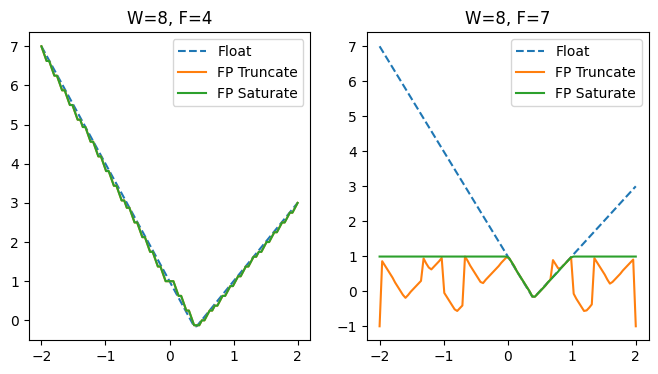

In [29]:
wid_plot = [8, 8]
fbits_plot = [4, 7]
nwid = len(wid_plot)
plt.subplots(1, nwid,figsize=(4*nwid, 4))

for i in range(nwid):

    wid = wid_plot[i]
    fbits = fbits_plot[i]
    xplot_int = (xplot * (1<<fbits)).astype(np.int64)
    aplot_int = (aplot * (1<<fbits)).astype(np.int64)

    # Create truncate version
    yplot_int_trunc = piecewise_fixed(xplot_int, aplot_int, wid=wid, fbits=fbits, sat=False)
    yplot_trunc = yplot_int_trunc.astype(np.float64) / (1<<fbits)

    # Create saturate version

    yplot_int_sat = piecewise_fixed(xplot_int, aplot_int, wid=wid, fbits=fbits, sat=True)
    yplot_sat = yplot_int_sat.astype(np.float64) / (1<<fbits)

    plt.subplot(1, nwid, i+1)
    plt.plot(xplot, yplot, label="Float", linestyle='dashed')
    plt.plot(xplot, yplot_trunc, label="FP Truncate")
    plt.plot(xplot, yplot_sat, label="FP Saturate")
    plt.title(f"W={wid}, F={fbits}")
    plt.legend()

## Optimizing the Bit-Widths

Now we test on random inputs and evaluate the MSE.

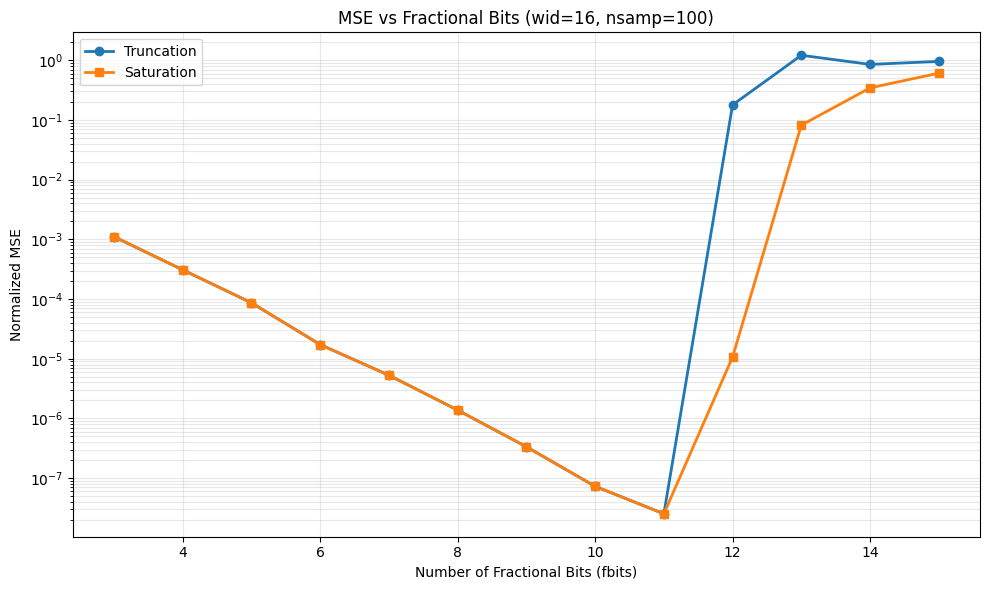


Statistics for wid=16, nsamp=100:
fbits    MSE (Trunc)     MSE (Sat)      
----------------------------------------
3        1.108076e-03    1.108076e-03   
4        3.082200e-04    3.082200e-04   
5        8.650120e-05    8.650120e-05   
6        1.724750e-05    1.724750e-05   
7        5.285429e-06    5.285429e-06   
8        1.378115e-06    1.378115e-06   
9        3.349644e-07    3.349644e-07   
10       7.286170e-08    7.286170e-08   
11       2.525042e-08    2.525042e-08   
12       1.787613e-01    1.068438e-05   
13       1.213676e+00    8.182438e-02   
14       8.524654e-01    3.443851e-01   
15       9.583662e-01    6.080004e-01   


In [31]:
# Generate random samples
nsamp = 100
np.random.seed(42)  # For reproducibility

# Random x values in range [-2, 2]
x = np.random.uniform(-2.0, 2.0, nsamp)

# Random a values - each sample has 4 coefficients
a = np.random.uniform(-4.0, 4.0, (nsamp, 4))

# Compute floating point output
y = piecewise_float(x, a)

# Setup bit-width parameters
wid = 16
fbits_test = np.arange(3, 16)

# Storage for MSE values
mse_trunc = np.zeros(len(fbits_test))
mse_sat = np.zeros(len(fbits_test))

# Loop over different fbits values
for i, fbits in enumerate(fbits_test):
    # Convert to fixed point representation
    x_int = np.round(x * (2**fbits)).astype(np.int64)
    a_int = np.round(a * (2**fbits)).astype(np.int64)
    
    # Compute with truncation
    y_int_trunc = piecewise_fixed(x_int, a_int, wid, fbits, sat=False)
    yhat_trunc = y_int_trunc / (2**fbits)
    mse_trunc[i] = np.mean((y - yhat_trunc)**2) / np.mean(y**2)
    
    # Compute with saturation
    y_int_sat = piecewise_fixed(x_int, a_int, wid, fbits, sat=True)
    yhat_sat = y_int_sat / (2**fbits)
    mse_sat[i] = np.mean((y - yhat_sat)**2) / np.mean(y**2)

# Plot MSE vs fbits in semilogy scale
plt.figure(figsize=(10, 6))
plt.semilogy(fbits_test, mse_trunc, 'o-', label='Truncation', linewidth=2)
plt.semilogy(fbits_test, mse_sat, 's-', label='Saturation', linewidth=2)
plt.xlabel('Number of Fractional Bits (fbits)')
plt.ylabel('Normalized MSE')
plt.title(f'MSE vs Fractional Bits (wid={wid}, nsamp={nsamp})')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nStatistics for wid={wid}, nsamp={nsamp}:")
print(f"{'fbits':<8} {'MSE (Trunc)':<15} {'MSE (Sat)':<15}")
print("-" * 40)
for i, fbits in enumerate(fbits_test):
    print(f"{fbits:<8} {mse_trunc[i]:<15.6e} {mse_sat[i]:<15.6e}")

## Key Findings

The analysis reveals important tradeoffs in fixed-point representation:

1. **For low fbits (3-11)**: Both truncation and saturation produce identical MSE values, which decrease steadily as fbits increases. This is expected behavior when there's no overflow.

2. **For high fbits (12-15)**: The MSE dramatically increases for truncation (reaching ~10+), while saturation maintains better control (though still degrading). This occurs because with a fixed total width of 16 bits and increasing fractional bits, the integer portion becomes too small, causing overflow issues:
   - At fbits=12: Only 4 bits for integer part (range: -8 to 7.999)
   - At fbits=15: Only 1 bit for integer part (range: -1 to 0.999)

3. **Optimal point**: Around fbits=11 gives the best MSE (~3×10⁻⁷) before overflow starts occurring.

The semilogy plot clearly visualizes this tradeoff between quantization error (which decreases with more fractional bits) and overflow error (which increases when there aren't enough integer bits to represent the values).

## Generate Test Vectors

We now generate test vectors for verification with the SystemVerilog implementation.

In [32]:
import os
import pandas as pd

# Create test_vectors directory if it doesn't exist
os.makedirs('test_vectors', exist_ok=True)

# Fix parameters for test vector generation
wid = 16
fbits = 8

# Convert to fixed point representation
x_int = np.round(x * (2**fbits)).astype(np.int64)
a_int = np.round(a * (2**fbits)).astype(np.int64)

# Compute with truncation
y_int_trunc = piecewise_fixed(x_int, a_int, wid, fbits, sat=False)
yhat_trunc = y_int_trunc / (2**fbits)

# Compute with saturation
y_int_sat = piecewise_fixed(x_int, a_int, wid, fbits, sat=True)
yhat_sat = y_int_sat / (2**fbits)

# Create DataFrame with all values
df = pd.DataFrame({
    'xint': x_int,
    'aint0': a_int[:, 0],
    'aint1': a_int[:, 1],
    'aint2': a_int[:, 2],
    'aint3': a_int[:, 3],
    'y': y,
    'yint_trunc': y_int_trunc,
    'yint_sat': y_int_sat,
    'yhat_trunc': yhat_trunc,
    'yhat_sat': yhat_sat
})

# Save to CSV file
csv_filename = f'test_vectors/tv_w{wid}_f{fbits}.csv'
df.to_csv(csv_filename, index=False)
print(f"Test vectors saved to {csv_filename}")
print(f"Number of test vectors: {len(df)}")
print(f"\nFirst 5 rows:")
print(df.head())

Test vectors saved to test_vectors/tv_w16_f8.csv
Number of test vectors: 100

First 5 rows:
   xint  aint0  aint1  aint2  aint3         y  yint_trunc  yint_sat  \
0  -128   -960    279   -380     18  2.972462         759       759   
1   462    835   -513   -184    523  3.872611         993       993   
2   238   -555   -866   -431   -694 -4.271074       -1095     -1095   
3   101    880    631    273    761  3.821549         978       978   
4  -352    622   -642    804     81 -4.006317       -1025     -1025   

   yhat_trunc  yhat_sat  
0    2.964844  2.964844  
1    3.878906  3.878906  
2   -4.277344 -4.277344  
3    3.820312  3.820312  
4   -4.003906 -4.003906  
